# Data Modelling

In [366]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import plot_tree

pd.set_option('display.max_columns', None)
style.use('seaborn-whitegrid')
sns.set_context('notebook', font_scale=1.2)

### Preparing Data for Modelling

In [3]:
ghome = pd.read_csv('../datasets/ghome_clean.csv')
aecho = pd.read_csv('../datasets/aecho_clean.csv')

In [6]:
df = pd.concat([ghome, aecho], ignore_index=True)

After joining both dataframes, we set r/amazonecho to correspond to 1 in our classification model as it is the majority class, with r/googlehome corresponding to 0. 

In [16]:
df['subreddit'] = df['subreddit'].map(lambda x: 1 if x=='amazonecho' else 0)

In [19]:
X = df['clean_post']
y = df['subreddit']

Looking at the value counts, just predicting the majority class would result in a 51% accuracy score, which is our baseline null model.

In [384]:
print(y.value_counts())
print(y.value_counts(normalize=True))

1    2609
0    2498
Name: subreddit, dtype: int64
1    0.510867
0    0.489133
Name: subreddit, dtype: float64


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### First Model Using Count Vectorizer and Logistic Regression

In order to model our data, we need to first feed the text data through CountVectorizer or TFIFD Vectorizer, which convert the words in each post into numerical data. Using TFIDFVectorizer allows our model to better ignore words that occur frequently across all posts which are less informative which were not included in the list of stopwords (e.g. device), and find words that are unique to each post. We also include 'google', 'home', 'amazon, and 'echo' in the list of stop words, to prevent the model from using these giveaway words to classify the posts. 

We then use 4 different techniques - Logistic Regression, Random Forest, Multinomial Naive Bayes, and Support Vector Classifier (SVC), and compare their accuracy score on the test set to determine the best model. This makes for a total of 8 permutations.

The first 2 techniques (Logistic Regression and Random Forest) were chosen as it is possible to get a ranking of feature importances, which shows which words help the model to accurately classify the post. Words that are more important would be indicative of topics/sentiment discussed unique to that subreddit. The next 2 techniques (Multinomial Naive Bayes and SVC) were chosen as benchmarks of comparison, given the wide use of both Multinomial Naive Bayes and SVC as text classifiers. However, Multinomial Naive Bayes has coefficients that are not easily interpretable in text classification problems, while SVC is a black box and thus does not cannot help in inference.

As the classes are relatively balanced, 51% to 48%, accuracy score is chosen as the metric of comparison to evaluate the performance of the model as it is easily interpretable and we are equally interested in minimizing false positives and false negatives.

In [ ]:
# Set up a dictionary to store model scores
results = {}

In [145]:
# Set up Pipeline
pipe = Pipeline([('cvec', CountVectorizer(stop_words=text.ENGLISH_STOP_WORDS.union(['google', 'home', 'amazon', 'echo']))),
                 ('logreg', LogisticRegression())])

In [149]:
# Define Parameters and run Gridsearch
params = {
    'cvec__max_features': [2500, 3000, 3500],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'logreg__C': [0.01, 0.1, 1]
}
gs = GridSearchCV(pipe, param_grid=params, cv=3)
gs.fit(X_train, y_train)
print(f'Best Cross-Validation Accuracy: {gs.best_score_}')
print(f'Accuracy on Train Set: {gs.score(X_train, y_train)}')
print(f'Accuracy on Test Set: {gs.score(X_test, y_test)}')
print(gs.best_params_)

Best Cross-Validation Accuracy: 0.8736297029103444
Accuracy on Train Set: 0.9151436031331592
Accuracy on Test Set: 0.8535630383711824
{'cvec__max_df': 0.9, 'cvec__max_features': 3000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'logreg__C': 0.01}


In [161]:
# Generate Confusion Matrix
pred = gs.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, pred),
                         columns=['pred_googlehome', 'pred_amazonecho'],
                         index=['actual_googlehome', 'actual_amazonecho'])

,pred_googlehome,pred_amazonecho
actual_googlehome,544,81
actual_amazonecho,106,546


In [162]:
# Generate Scores
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f'Accuracy: {accuracy}')

sensitivity = tp / (tp + fn)
print(f'Sensitivity: {sensitivity}')

specificity = tn / (tn + fp)
print(f'Specificity: {specificity}')

precision = tp / (tp + fp)
print(f'Precision: {precision}')

Accuracy: 0.8535630383711824
Sensitivity: 0.8374233128834356
Specificity: 0.8704
Precision: 0.8708133971291866


In [163]:
# Save scores to results
results['cvec_logreg'] = [gs.score(X_train, y_train), gs.score(X_test, y_test),
                            sensitivity, specificity, precision]

In [151]:
# Examine feature importances
coef.sort_values('coef', ascending=True).head(20)

,coef
nest,-0.670732
mini,-0.620359
assistant,-0.470890
hub,-0.348970
chromecast,-0.295793
speaker,-0.260731
hey,-0.253652
app,-0.193865
gh,-0.185647
nest hub,-0.184344


In [150]:
# Examine feature importances
coef = pd.DataFrame(gs.best_estimator_.named_steps['logreg'].coef_.T,index=gs.best_estimator_.named_steps['cvec'].get_feature_names(), columns=['coef'])
coef.sort_values('coef', ascending=False).head(20)

,coef
alexa,1.180783
dot,0.786842
gen,0.354374
skill,0.301190
studio,0.296466
alexa app,0.196573
4th,0.181208
prime,0.144895
4th gen,0.142408
want,0.135105


### Setting Up Pipelines for Other Classification Methods using Count Vectorizer and TFIDF Vectorizer

In [168]:
# CountVectorizer + Multimonial Naive Bayes
pipe_cvec_mnb = Pipeline([('cvec', CountVectorizer(stop_words=text.ENGLISH_STOP_WORDS.union(['google', 'home', 'amazon', 'echo']))),
                 ('mnb', MultinomialNB())
                 ])

# CountVectorizer + Random Forest
pipe_cvec_rf = Pipeline([('cvec', CountVectorizer(stop_words=text.ENGLISH_STOP_WORDS.union(['google', 'home', 'amazon', 'echo']))),
                 ('rf', RandomForestClassifier())
                 ])

# CountVectorizer + Support Vector Classifier
pipe_cvec_svc = Pipeline([('cvec', CountVectorizer(stop_words=text.ENGLISH_STOP_WORDS.union(['google', 'home', 'amazon', 'echo']))),
                 ('svc', SVC())
                 ])

In [202]:
# TFIDFVectorizer + Logistic Regression
pipe_tvec_logreg = Pipeline([('tvec', TfidfVectorizer(stop_words=text.ENGLISH_STOP_WORDS.union(['google', 'home', 'amazon', 'echo']))),
                 ('logreg', LogisticRegression())
                 ])

# TFIDFVectorizer + Multinomial Naive Bayes
pipe_tvec_mnb = Pipeline([('tvec', TfidfVectorizer(stop_words=text.ENGLISH_STOP_WORDS.union(['google', 'home', 'amazon', 'echo']))),
                 ('mnb', MultinomialNB())
                 ])

# TFIDFVectorizer + Random Forest
pipe_tvec_rf = Pipeline([('tvec', TfidfVectorizer(stop_words=text.ENGLISH_STOP_WORDS.union(['google', 'home', 'amazon', 'echo']))),
                 ('rf', RandomForestClassifier())
                 ])

# TFIDFVectorizer + Support Vector Classifier
pipe_tvec_svc = Pipeline([('tvec', TfidfVectorizer(stop_words=text.ENGLISH_STOP_WORDS.union(['google', 'home', 'amazon', 'echo']))),
                 ('svc', SVC())
                 ])

In [183]:
params_cvec_mnb = {
    'cvec__max_features': [2500, 3000, 3500],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'mnb__alpha': [0.01, 0.05, 0.5, 0.95, 1],
}

params_cvec_rf = {
    'cvec__max_features': [2500, 3000, 3500],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'rf__max_depth' : [3, 4],
    'rf__min_samples_split': [2, 3],
    'rf__min_samples_leaf': [2, 3],
    'rf__n_estimators': [100, 150, 200],
    'rf__max_features': ['auto', 'log2', None]
}

params_cvec_svc = {
    'cvec__max_features': [2500, 3000, 3500],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'svc__kernel': ['rbf'],
    'svc__C': np.logspace(0.0001, 1, 20)
}

In [222]:
params_tvec_logreg = {
    'tvec__max_features': [2500, 3000, 3500],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)],
    'logreg__C': [0.01, 0.1, 1]
}

params_tvec_mnb = {
    'tvec__max_features': [2500, 3000, 3500],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)],
    'mnb__alpha': [0.01, 0.05, 0.5, 0.95, 1],
}

params_tvec_rf = {
    'tvec__max_features': [2500, 3000, 3500],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)],
    'rf__max_depth' : [3, 4],
    'rf__min_samples_split': [2, 3],
    'rf__min_samples_leaf': [2, 3],
    'rf__n_estimators': [100, 150, 200],
    'rf__max_features': ['auto']
}

params_tvec_svc = {
    'tvec__max_features': [2500, 3000, 3500],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)],
    'svc__degree': [2],
    'svc__kernel': ['rbf', 'poly'],
    'svc__C': np.logspace(0.0001, 1, 20)
}

In [188]:
def model(pipe, params, name):
    """
    Inputs: Pipeline, Parameters for the Pipeline, Name of the Model
    Output: Runs the corresponding model and saves accuracy scores to results dictionary
    """
    gs = GridSearchCV(pipe,params,cv=3,verbose=1,n_jobs=-1) # Runs Model 
    gs.fit(X_train, y_train)
    print(f'Best Cross-Validation Accuracy: {gs.best_score_}')
    print(f'Accuracy on Train Set: {gs.score(X_train, y_train)}')
    print(f'Accuracy on Test Set: {gs.score(X_test, y_test)}')
    print(gs.best_params_)

    print('')
    
    pred = gs.predict(X_test) # Generates Confusion Matrix and Scores
    print(pd.DataFrame(confusion_matrix(y_test, pred),
                         columns=['pred_googlehome', 'pred_amazonecho'],
                         index=['actual_googlehome', 'actual_amazonecho']))
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    sensitivity = tp / (tp + fn)
    print(f'Sensitivity: {sensitivity}')
    specificity = tn / (tn + fp)
    print(f'Specificity: {specificity}')
    precision = tp / (tp + fp)
    print(f'Precision: {precision}')
    
    results[name] = [gs.score(X_train, y_train), gs.score(X_test, y_test), sensitivity, specificity, precision] # Saves scores to result dictionary

### Running each model

In [189]:
model(pipe_cvec_mnb, params_cvec_mnb, 'cvec_mnb')

Fitting 3 folds for each of 120 candidates, totalling 360 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   56.1s finished
Best Cross-Validation Accuracy: 0.8676250256732528
Accuracy on Train Set: 0.918798955613577
Accuracy on Test Set: 0.851213782302271
{'cvec__max_df': 0.9, 'cvec__max_features': 2500, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'mnb__alpha': 0.95}

                   pred_googlehome  pred_amazonecho
actual_googlehome              536               89
actual_amazonecho              101              551
Sensitivity: 0.8450920245398773
Specificity: 0.8576
Precision: 0.8609375


In [191]:
model(pipe_cvec_rf, params_cvec_rf, 'cvec_rf')

Fitting 3 folds for each of 1728 candidates, totalling 5184 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 28.4min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 35.8min
[Parallel(n_jobs=-1)]: Done 5184 out of 5184 | elapsed: 37.6min finished
Best Cross-Validation Accuracy: 0.8561375235355199
Accuracy on Train Set: 0.8827676240208877
Accuracy on Test Set: 0.841033672670321
{'cvec__max_df': 0.9, 'cvec

In [193]:
model(pipe_cvec_svc, params_cvec_svc, 'cvec_svc')

Fitting 3 folds for each of 480 candidates, totalling 1440 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 14.2min finished
Best Cross-Validation Accuracy: 0.8697148898320827
Accuracy on Train Set: 0.9592689295039164
Accuracy on Test Set: 0.8433829287392326
{'cvec__max_df': 0.9, 'cvec__max_features': 2500, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'svc__C': 1.0002302850208247, 'svc__kernel': 'rbf'}

                   pred_googlehome  pred_amazonecho
actual_googlehome              535               90
actual_amazonecho              110              542
Sensitivity: 0.8312883435582822
Spe

In [203]:
model(pipe_tvec_logreg, params_tvec_logreg, 'tvec_logreg')

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   37.3s finished
Best Cross-Validation Accuracy: 0.8780688231380857
Accuracy on Train Set: 0.9530026109660574
Accuracy on Test Set: 0.8684416601409554
{'logreg__C': 1, 'tvec__max_df': 0.9, 'tvec__max_features': 2500, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}

                   pred_googlehome  pred_amazonecho
actual_googlehome              550               75
actual_amazonecho               93              559
Sensitivity: 0.8573619631901841
Specificity: 0.88
Precision: 0.8817034700315457


In [212]:
model(pipe_tvec_mnb, params_tvec_mnb, 'tvec_mnb')

Fitting 3 folds for each of 120 candidates, totalling 360 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   54.6s finished
Best Cross-Validation Accuracy: 0.8582249328813205
Accuracy on Train Set: 0.9412532637075718
Accuracy on Test Set: 0.855912294440094
{'mnb__alpha': 1, 'tvec__max_df': 0.9, 'tvec__max_features': 3500, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}

                   pred_googlehome  pred_amazonecho
actual_googlehome              530               95
actual_amazonecho               89              563
Sensitivity: 0.8634969325153374
Specificity: 0.848
Precision: 0.8556231003039514


In [214]:
model(pipe_tvec_rf, params_tvec_rf, 'tvec_rf')

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed:  9.2min finished
Best Cross-Validation Accuracy: 0.8587486263275425
Accuracy on Train Set: 0.8428198433420365
Accuracy on Test Set: 0.7877838684416602
{'rf__max_depth': 4, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 150, 'tvec__max_df': 0.9, 'tvec__max_features': 3000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}

                   pred_googlehome  pred_amazonecho
actual_googlehome              388              237
actual_amaz

In [241]:
model(pipe_tvec_svc, params_tvec_svc, 'tvec_svc')

Fitting 3 folds for each of 960 candidates, totalling 2880 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 34.0min finished
Best Cross-Validation Accuracy: 0.8785919028810504
Accuracy on Train Set: 0.995822454308094
Accuracy on Test Set: 0.8629600626468285
{'svc__C': 1.0002302850208247, 'svc__degree': 2, 'svc__kernel': 'rbf', 'tvec__max_df': 0.9, 'tvec__max_features': 2500, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 1)}

                   pred_googlehome  pred_amazone

### Determining Best Model

In [250]:
# Turning results dictionary into dataframe
df_results = pd.DataFrame(results, index=['train_set_acc', 'test_set_acc', 'sensitivity', 'specificity', 'precision']).T

In [251]:
df_results

,train_set_acc,test_set_acc,sensitivity,specificity,precision
cvec_logreg,0.915144,0.853563,0.837423,0.8704,0.870813
cvec_mnb,0.918799,0.851214,0.845092,0.8576,0.860938
cvec_rf,0.882768,0.841034,0.918712,0.7600,0.799733
cvec_svc,0.959269,0.843383,0.831288,0.8560,0.857595
tvec_logreg,0.953003,0.868442,0.857362,0.8800,0.881703
tvec_mnb,0.941253,0.855912,0.863497,0.8480,0.855623
tvec_rf,0.842820,0.787784,0.947853,0.6208,0.722807
tvec_svc,0.995822,0.862960,0.846626,0.8800,0.880383


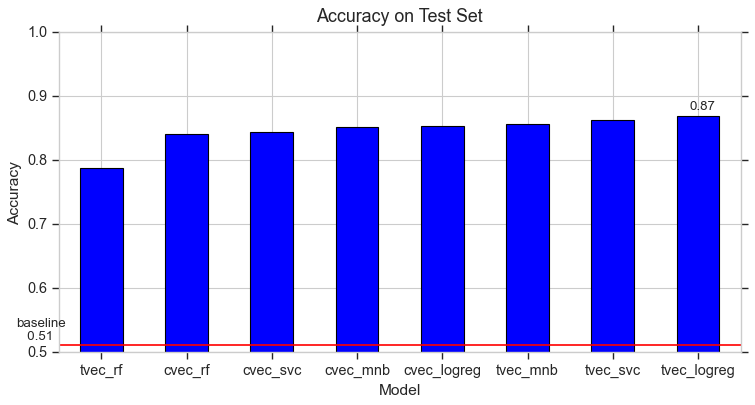

In [444]:
df_results.sort_values('test_set_acc')['test_set_acc'].plot(kind='bar', figsize=(11,5))

plt.title('Accuracy on Test Set', size=16, pad=10)
plt.axhline(y=0.5108, color='r')
plt.text(s='baseline\n   0.51', x=-1, y=0.52, size=12)
plt.text(s='0.87', x=6.9, y=0.88, size=12)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0.5, 1)
plt.xticks(size=13, rotation=0)
plt.yticks(size=13)
plt.savefig('../images/model_scores.png', bbox_inches='tight', facecolor='w')
plt.show()

While all models did much better than the baseline, the TFIDFVectorizer-Logistic Regression model has the best accuracy score on the test set indicating low variance and low bias, and we will use this model to infer our findings. 

Logistic Regression allows us to model a binary variable using linear boundaries by mapping each predicted value to a probability between 0 and 1 using a Sigmoid function. Probabilities are then classified to 1 and 0 based on whether they are closer to 1 or 0.

Support Vector Machine Classification may have done worse due to significant overfitting. The difference between the train score and test score for SVC is far bigger compared to that of Logistic Regression. We may need to try different values of Gamma.

Multinomial Bayes may have done worse as it assumes independence amongst predictors, which is not likely to be a valid assumption for text classification.

Random Forests may have done worse as it may be constrained in its hyperparameters, e.g. max_depth may need to be increased as many features matter in order for an accurate classification, and n_estimators may need to be increased to allow for the model to try greater combinations of different features.

TFIDFVectorizer also does better overall than CountVectorizer, showing how TFIDFVectorizer helps the model to pick out more unique words with more information. 

### Inspecting Predictions of Best Model

In [272]:
tvec_logreg_best_params = {'logreg__C': [1], 'tvec__max_df': [0.9], 'tvec__max_features': [2500], 'tvec__min_df': [2], 'tvec__ngram_range': [(1, 2)]} # Extracting best params of best model
gs = GridSearchCV(pipe_tvec_logreg,tvec_logreg_best_params,cv=3) # Refitting using best params
gs.fit(X_train, y_train)
coef_tvec = pd.DataFrame(gs.best_estimator_.named_steps['logreg'].coef_.T,index=gs.best_estimator_.named_steps['tvec'].get_feature_names(), columns=['coef']) # Extracting coefficients

#### ROC-AUC Score
Looking at the ROC curve, the model is able to distinguish between the two subreddits well, as the curve is near the top left corner of the graph.

In [368]:
preds = gs.predict(X_test) # Getting preds
preds_prob = gs.predict_proba(X_test) # Getting predicted probabilities
preds_prob = preds_prob[:,1]
roc_auc_score(y_test, preds_prob) # Computing ROC-AUC score

0.944358282208589

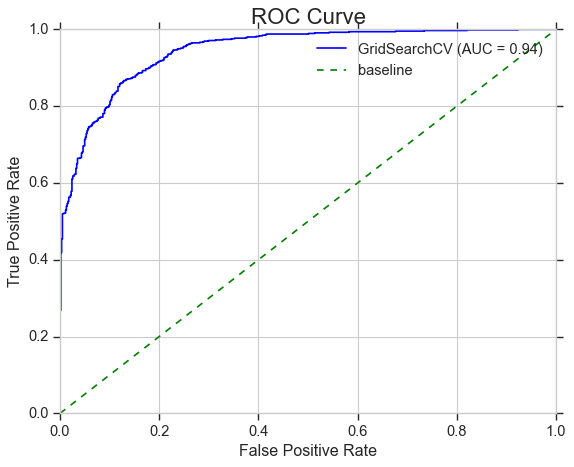

In [382]:
plot_roc_curve(gs, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.title('ROC Curve', size=20)
plt.legend()
plt.show()

#### Top words for prediction
The most useful words for prediction to the model are mainly brand related words. 

In [404]:
coef_tvec.sort_values('coef', ascending=True).head(20)

,coef
nest,-6.544811
mini,-6.092967
assistant,-4.294799
hub,-3.599369
chromecast,-3.220855
speaker,-2.715176
hey,-2.525673
gh,-2.374119
nest hub,-2.172065
max,-2.023757


In [307]:
df_test = pd.DataFrame(y_test)
df_preds = pd.DataFrame(preds, index=y_test.index)
df_best_model = pd.concat([df_test, df_preds], axis=1)
df_best_model.rename(columns={'subreddit': 'actual', 0: 'preds'}, inplace=True)

In [405]:
coef_tvec.sort_values('coef', ascending=False).head(20)

,coef
alexa,11.539101
dot,7.519150
skill,3.208561
gen,3.113916
studio,2.933709
alexa app,2.663119
prime,1.855174
4th,1.835845
bud,1.573177
ring,1.526353


#### Examining misclassified posts

In [316]:
df_best_model['wrong'] = abs(df_best_model['actual'] - df_best_model['preds']) # Creating wrong indices column
df_best_model[df_best_model['wrong']==1].head(20)

,actual,preds,wrong
3625,1,0,1
4669,1,0,1
4326,1,0,1
3224,1,0,1
1408,0,1,1
50,0,1,1
5070,1,0,1
2328,0,1,1
475,0,1,1
784,0,1,1


In [337]:
df_best_model['wrong'].sum()

168

In [437]:
df.loc[df_best_model[df_best_model['wrong']==1].index,['subreddit', 'clean_post']].head(10)

,subreddit,clean_post
3625,1,can you connect firecube to both tv speaker an...
4669,1,connecting to pc | okay so essentially i have ...
4326,1,i just got a google hub it show nice picture m...
3224,1,echo not on same wifi but they are | strange i...
1408,0,anybody have any experience with using crypto ...
50,0,google store problem placing an order | so i h...
5070,1,new smart home interface on fire tablet hope t...
2328,0,question about room device naming | new to goo...
475,0,quiter than normal | so ive thought i might ha...
784,0,ok google 96 divided by 2 google home streamin...


Looking at the misclassified posts, some are misclassified due to short word count or posts unrelated to the subreddit which result in a lack of information for the model, while others involve comparisons between google and amazon that may belong in either subreddit.

In [327]:
df.loc[4669,'clean_post']

'connecting to pc | okay so essentially i have a strand of light plugged into a smart plug is it possible to have the light turn on off when my pc turn on off'

In [328]:
df.loc[4326,'clean_post']

'i just got a google hub it show nice picture my echo show mostly show ad and annoying sh t can i turn that off and only show picture | my echo show show idiotic stuff like the last song i played on a different device why tf would i care about that and commercial for movie i dont want to watch i just want it to show me the time and my photo unless i ask for something can i turn off this spam ive looked at the setting and found nothing on my own'

In [330]:
df.loc[1408,'clean_post']

'anybody have any experience with using crypto signaling and who would you recommend |'

In [331]:
df.loc[50,'clean_post']

'google store problem placing an order | so i have a few item in my cart i go to check out and it just brings me to a black screen ive tried different internet browser ive tried on my phone it wont let me complete the checkout ha anyone else struggled with placing an order through the google store the past few day'

In [332]:
df.loc[5070,'clean_post']

'new smart home interface on fire tablet hope this come to the new show |'

#### Sentiment Analysis

In order to analyse sentiment, positive valence words and negative valence words were chosen and their coefficients examined. Under logistic regression, posts with words with higher coefficients would generally result in a predicted probability close to 1, resulting in the post being classified as under r/amazonecho. Conversely, posts with words with lower coefficients would result in a predicted probability close to 0, resulting in the post being classified as under r/googlehome. Hence, words with higher coefficients indicate that they are more unique to the r/amazonecho subreddit, while the words with lower coefficients indicate that they are more unique to the r/googlehome subreddit.

The coefficients for positive words seem to be higher than the coefficient for negative words. We infer that r/amazonecho seems to have more positive sentiment compared to r/googlehome.

In [381]:
print(f'Coefficient for \'good\': {coef_tvec.loc["good", :][0]}')
print(f'Coefficient for \'great\': {coef_tvec.loc["great", :][0]}')
print(f'Coefficient for \'best\': {coef_tvec.loc["best", :][0]}')
print(f'Coefficient for \'happy\': {coef_tvec.loc["happy", :][0]}')
print(f'Coefficient for \'love\': {coef_tvec.loc["love", :][0]}')

print(' ')
print(f'Coefficient for \'bad\': {coef_tvec.loc["bad", :][0]}')
print(f'Coefficient for \'terrible\': {coef_tvec.loc["terrible", :][0]}')
print(f'Coefficient for \'horrible\': {coef_tvec.loc["horrible", :][0]}')
print(f'Coefficient for \'issue\': {coef_tvec.loc["issue", :][0]}')
print(f'Coefficient for \'problem\': {coef_tvec.loc["problem", :][0]}')

Coefficient for 'good': 0.2442363745939605
Coefficient for 'great': 0.5523323473100897
Coefficient for 'best': 0.1608618383975604
Coefficient for 'happy': 0.10638560832739494
Coefficient for 'love': 0.5097944532449921
 
Coefficient for 'bad': -0.38764733613472535
Coefficient for 'terrible': 0.09901169793414415
Coefficient for 'horrible': 0.08491289344867509
Coefficient for 'issue': -0.10671726451620198
Coefficient for 'problem': 0.10929821574220881
